# Lab 1 Project - Corpus Analysis 
The following notebook contains code and comments related to exploratory analysis of the preprocessed data. The starting dataset for this notebook are `preprocessed_reviews_games.csv` and   `preprocessed_validationset.csv`. The first part of the code merges the 2 datasets and computes ownership tiers based on the quantile distribution on average_owners. A checkpoint is present where the merged datasets are directly loaded from `merged_data.csv`.

In [1]:
# DF processing libraries
import pandas as pd
import numpy as np
# Text processing libraries
import nltk
# Data source fetching library
import kagglehub
# Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Multicore processing library
import os
import ast

Two datasets are loaded. Reviews1 is the original kaggle dataset, Reviews2 is the new data scraped from steam on 31.01. Finally reviews_c is the combined dataset. Deduplication not needed since reveiws1 was published in late december whereas reveiws2 contains data from 03.01.25 to 31.01.25 hence no overlay can occur. 

In [2]:
reviews1 = pd.read_csv('./preprocessed_reviews_games.csv')
reviews2 = pd.read_csv('./preprocessed_validationset.csv')

In [3]:
merged_data = pd.concat([reviews1, reviews2])
merged_data.dropna(inplace=True)
merged_data.head()

,id,app_id,content,author_id,score,name,average_owners,tokens,cleaned_content
0,181398278,630,my friend fucking glitched out of the map. dud...,76561199715566328,0,Alien Swarm,3500000.0,"['friend', 'fucking', 'glitched', 'map', 'dude']",friend fucking glitched map dude
1,175959006,630,nobody is playing this game,76561198880505482,0,Alien Swarm,3500000.0,"['nobody', 'playing', 'game']",nobody playing game
2,175942905,630,this game isn't very fun it runs like ass and ...,76561199208923353,0,Alien Swarm,3500000.0,"['game', 'fun', 'run', 'like', 'as', 'communit...",game fun run like as community ready kick soon...
3,175501438,630,last mission was so hard,76561199229157735,0,Alien Swarm,3500000.0,"['last', 'mission', 'hard']",last mission hard
4,170983852,630,As an avid fan of Alien Shooter 2 from its hey...,76561199687240931,0,Alien Swarm,3500000.0,"['avid', 'fan', 'alien', 'shooter', 'heyday', ...",avid fan alien shooter heyday approached game ...


Create bins for avg. game owners using quantiles. 

In [4]:
labels = ['Low', 'Medium', 'High']
# Calculate percentiles
percentiles = merged_data['average_owners'].quantile([0, 0.33, 0.66, 1.0])
# Use percentiles as bin edges
merged_data['ownership_tier'] = pd.cut(merged_data['average_owners'], bins=percentiles, labels=labels, include_lowest=True)
merged_data.head()

,id,app_id,content,author_id,score,name,average_owners,tokens,cleaned_content,ownership_tier
0,181398278,630,my friend fucking glitched out of the map. dud...,76561199715566328,0,Alien Swarm,3500000.0,"['friend', 'fucking', 'glitched', 'map', 'dude']",friend fucking glitched map dude,Low
1,175959006,630,nobody is playing this game,76561198880505482,0,Alien Swarm,3500000.0,"['nobody', 'playing', 'game']",nobody playing game,Low
2,175942905,630,this game isn't very fun it runs like ass and ...,76561199208923353,0,Alien Swarm,3500000.0,"['game', 'fun', 'run', 'like', 'as', 'communit...",game fun run like as community ready kick soon...,Low
3,175501438,630,last mission was so hard,76561199229157735,0,Alien Swarm,3500000.0,"['last', 'mission', 'hard']",last mission hard,Low
4,170983852,630,As an avid fan of Alien Shooter 2 from its hey...,76561199687240931,0,Alien Swarm,3500000.0,"['avid', 'fan', 'alien', 'shooter', 'heyday', ...",avid fan alien shooter heyday approached game ...,Low


In [5]:
# Update merged dataset with new df
merged_data.to_csv('merged_data.csv')

In [6]:
merged_data.ownership_tier.value_counts()

ownership_tier
Medium    132648
Low       128928
High      123355
Name: count, dtype: int64

# Checkpoint: loading merged data
We can load the merged data dataframe from the .csv file. Unfortunatly the list of tokens gets converted to a string, so with the following code snippet this is fixed by use of `ast`.

In [7]:
merged_data = pd.read_csv('merged_data.csv', dtype={'ownership_tier': pd.CategoricalDtype(categories=['Low', 'Medium', 'High'], 
                                                                                          ordered=True)},
                          converters={'tokens': ast.literal_eval,
                                      'filtered_tokens': ast.literal_eval})

In [8]:
merged_data.head()

,Unnamed: 0,id,app_id,content,author_id,score,name,average_owners,tokens,cleaned_content,ownership_tier
0,0,181398278,630,my friend fucking glitched out of the map. dud...,76561199715566328,0,Alien Swarm,3500000.0,"[friend, fucking, glitched, map, dude]",friend fucking glitched map dude,Low
1,1,175959006,630,nobody is playing this game,76561198880505482,0,Alien Swarm,3500000.0,"[nobody, playing, game]",nobody playing game,Low
2,2,175942905,630,this game isn't very fun it runs like ass and ...,76561199208923353,0,Alien Swarm,3500000.0,"[game, fun, run, like, as, community, ready, k...",game fun run like as community ready kick soon...,Low
3,3,175501438,630,last mission was so hard,76561199229157735,0,Alien Swarm,3500000.0,"[last, mission, hard]",last mission hard,Low
4,4,170983852,630,As an avid fan of Alien Shooter 2 from its hey...,76561199687240931,0,Alien Swarm,3500000.0,"[avid, fan, alien, shooter, heyday, approached...",avid fan alien shooter heyday approached game ...,Low


# Analysing word frequency 
Let's start with finding out some metrics on the cleaned data such as average tokens per review, total tokens and tokens present in more than 10% of reviews. 

In [9]:
from collections import Counter
import itertools

# Total reviews 
tot_reviews = len(merged_data)
print(f'Number of reviews: {tot_reviews}')

# Computing avg tokens per review
avg_tokens = merged_data.tokens.apply(len).mean()
print(f'Average tokens per reviews: {avg_tokens}')

tot_tokens = merged_data.tokens.apply(len).sum()
print(f'Total tokens in corpus of reviews: {tot_tokens}')


token_review_count = Counter(token for tokens in merged_data['tokens'] for token in set(tokens))
threshold = 0.10 * len(merged_data)
common_tokens = [token for token, count in token_review_count.items() if count >= threshold]

print(f"Tokens present in more than 10% of reviews: {common_tokens}")
print(f'Number of unique tokens(words) in corpus: {len(token_review_count)}')

Number of reviews: 384931
Average tokens per reviews: 20.002914808108468
Total tokens in corpus of reviews: 7699742
Tokens present in more than 10% of reviews: ['game', 'fun', 'time', 'like', 'play', 'get', 'good', 'one']
Number of unique tokens(words) in corpus: 138238


The set of unique words used in the corpus of all reviews is very large. It could be beneficial to narrow it down, for instance by removing very frequent and very unfrequent words. After creating a table containing all unique tokens and the percentage of the document they show up in I came up with the following criterion to reduce the total number of tokens:
- Remove infrequently used words by removing tokens appearing in less than 0.05% of the corpus
- Remove common words by removing tokens appearing in more than 7% of the corpus

In [10]:
# Create a DataFrame from the token counts and compute percentage of document frequency
token_df = pd.DataFrame(token_review_count.items(), columns=['token', 'doc_count'])
token_df['percentage'] = (token_df['doc_count'] / tot_reviews) * 100
token_df_top_50 = token_df.sort_values(by='doc_count', ascending=False)[:50]
token_df_top_50

,token,doc_count,percentage
6,game,217881,56.602612
146,play,60148,15.625658
13,fun,57201,14.860066
161,good,55751,14.483375
23,like,50105,13.016619
15,time,43878,11.398926
156,get,42304,10.990022
288,one,39725,10.320031
662,great,36584,9.504041
649,best,29851,7.754896


It seems like most of the infrequent tokens are user typos. 

In [11]:
tokens_bottom_50 = token_df.sort_values(by='doc_count', ascending=False)[-50:]
tokens_bottom_50

,token,doc_count,percentage
17180,hardsome,1,0.00026
17181,enjoinablegood,1,0.00026
17192,nastolgic,1,0.00026
17194,visitsee,1,0.00026
17196,topkek,1,0.00026
17250,kwebblekop,1,0.00026
73728,yakuzashenmue,1,0.00026
73727,remindend,1,0.00026
73687,riskim,1,0.00026
73696,sukit,1,0.00026


In [12]:
lower_threshold = 0.01  # tokens must appear in at least 0.05% of reviews
upper_threshold = 7.0    # tokens must appear in no more than 7% of reviews

# Identify tokens that meet both criteria
allowed_tokens = set(
    token_df[
        (token_df['percentage'] >= lower_threshold) & 
        (token_df['percentage'] <= upper_threshold)
    ]['token']
)

In [13]:
print(f"Total tokens: {len(token_df)}")
print(f"Allowed tokens after filtering: {len(allowed_tokens)} -> {100.0 - len(allowed_tokens)/len(token_df)*100:.2f}% token count reduction.")

Total tokens: 138238
Allowed tokens after filtering: 8897 -> 93.56% token count reduction.


Applying the selection of tokens to the `tokens` list from the initial dataset of merged data and storing the output in `filtered_tokens`

In [14]:
# Filter the tokens in each review using the allowed tokens
merged_data['filtered_tokens'] = merged_data['tokens'].apply(
    lambda tokens: [token for token in tokens if token in allowed_tokens]
)

In [15]:
merged_data['filtered_tokens'].isna().sum()

0

In [16]:
merged_data.to_csv('filtered_merged_data.csv')

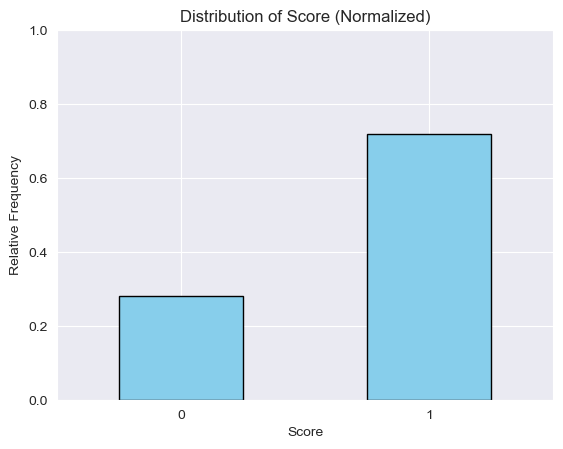

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

proportions = merged_data['score'].value_counts(normalize=True).sort_index()
proportions.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Score')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=0)
plt.title('Distribution of Score (Normalized)')
plt.ylim(0, 1) 
plt.show()

C:\Users\vnvtr\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


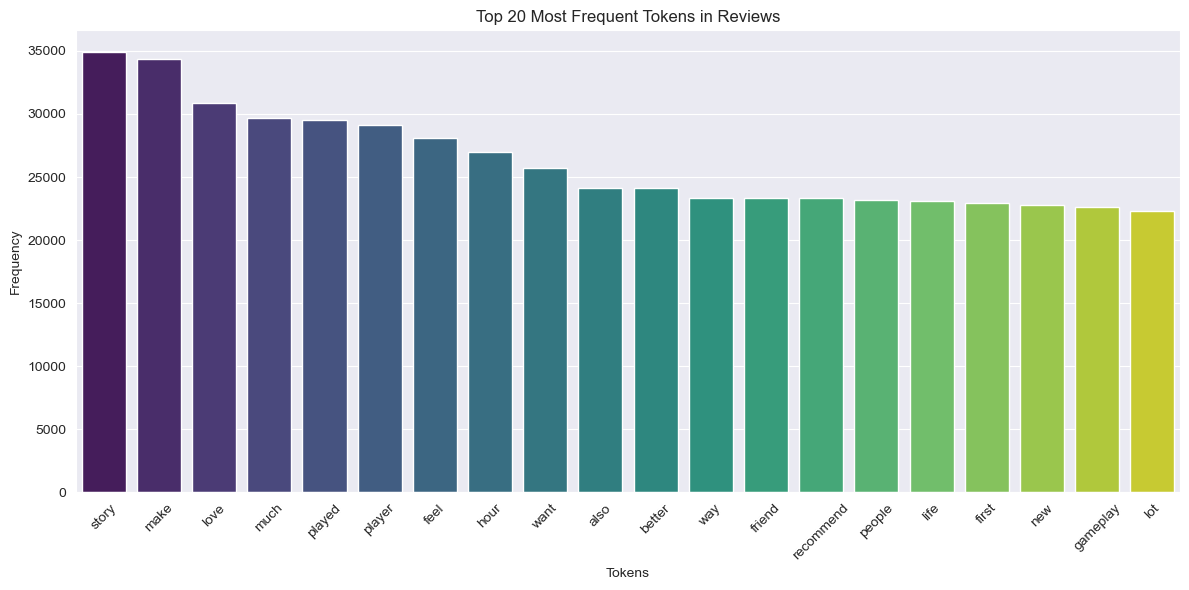

In [17]:
# Flatten the list of filtered tokens from all reviews into a single list
all_filtered_tokens = merged_data['filtered_tokens'].explode()

# Compute the frequency of each token
token_counts = Counter(all_filtered_tokens)

# Get the top 20 most common tokens
top_tokens = token_counts.most_common(20)
tokens, counts = zip(*top_tokens)

# Plot the top tokens
plt.figure(figsize=(12, 6))
sns.barplot(x=list(tokens), y=list(counts), palette='viridis')
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Tokens in Reviews")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

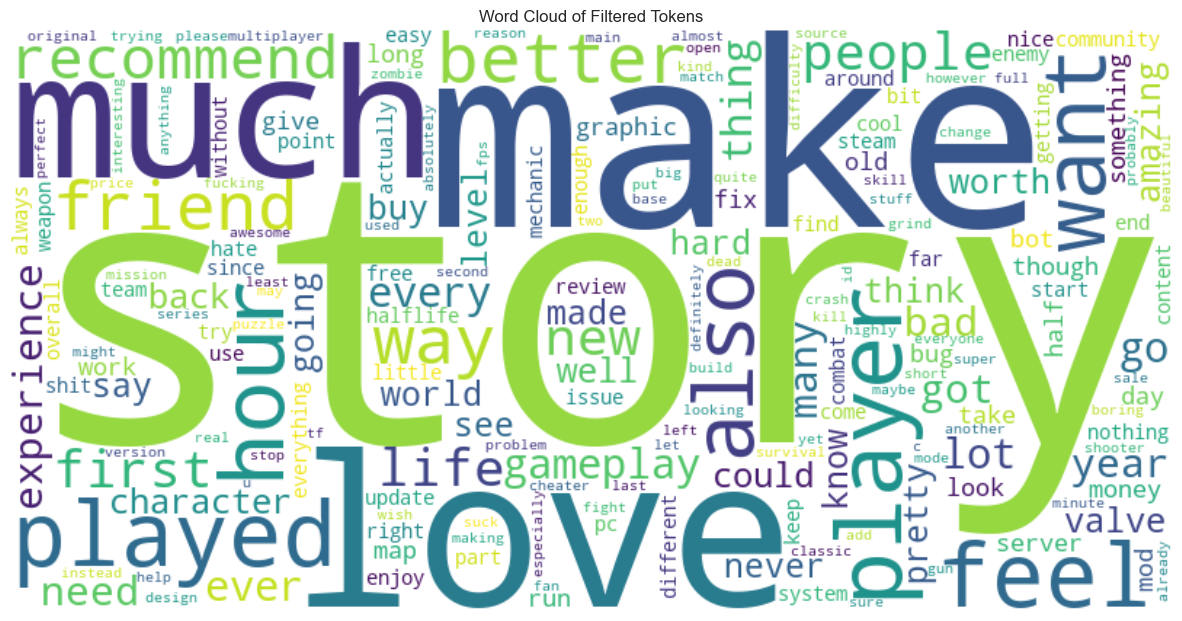

In [18]:
from wordcloud import WordCloud

# Create the word cloud using the token frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Filtered Tokens")
plt.show()

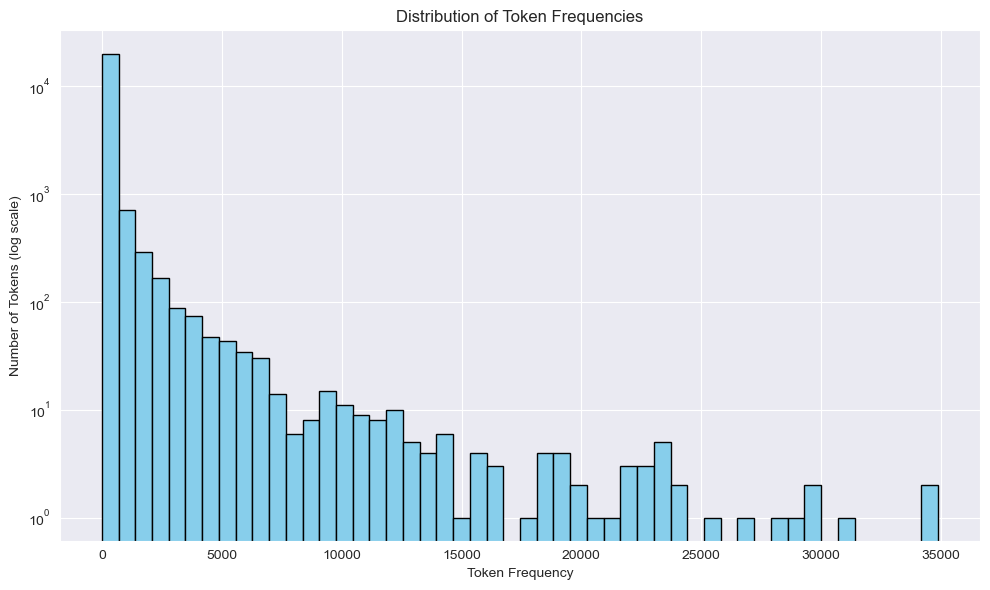

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(list(token_counts.values()), bins=50, log=True, color='skyblue', edgecolor='black')
plt.xlabel("Token Frequency")
plt.ylabel("Number of Tokens (log scale)")
plt.title("Distribution of Token Frequencies")
plt.tight_layout()
plt.show()

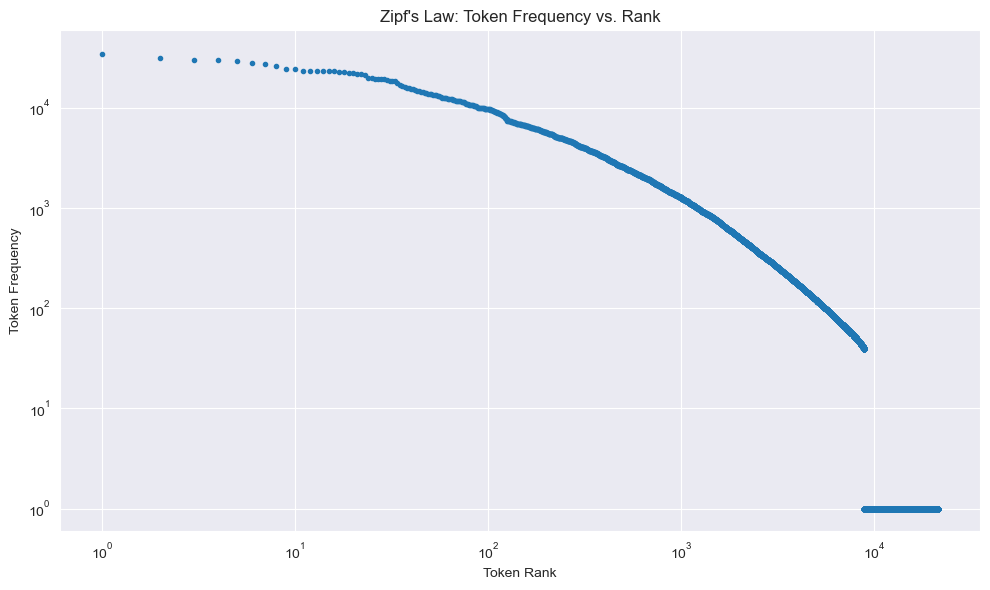

In [20]:
# Sort token frequencies in descending order
sorted_freqs = sorted(token_counts.values(), reverse=True)

plt.figure(figsize=(10, 6))
plt.plot(sorted_freqs, marker='.', linestyle='none')
plt.xlabel("Token Rank")
plt.ylabel("Token Frequency")
plt.title("Zipf's Law: Token Frequency vs. Rank")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.show()

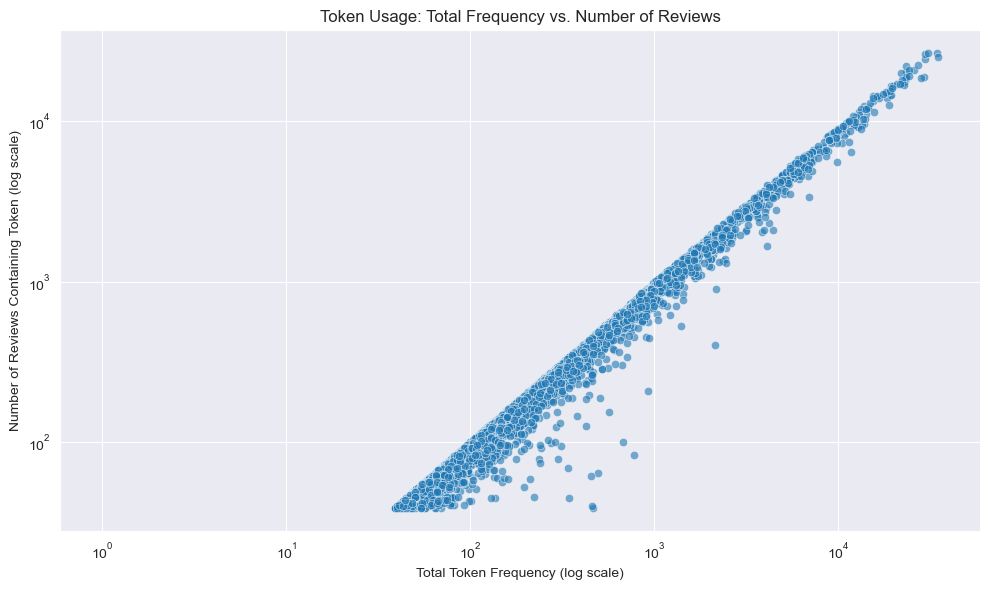

In [21]:
# Calculate how many reviews each token appears in
token_review_count = Counter(token for tokens in merged_data['tokens'] for token in set(tokens))

# Prepare a DataFrame with both total frequency and review count for each token
import pandas as pd

tokens_data = [
    (token, token_counts[token], token_review_count.get(token, 0))
    for token in token_counts
]
df_tokens = pd.DataFrame(tokens_data, columns=['token', 'total_freq', 'review_freq'])

# Scatter plot with log scales
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tokens, x='total_freq', y='review_freq', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Total Token Frequency (log scale)")
plt.ylabel("Number of Reviews Containing Token (log scale)")
plt.title("Token Usage: Total Frequency vs. Number of Reviews")
plt.tight_layout()
plt.show()

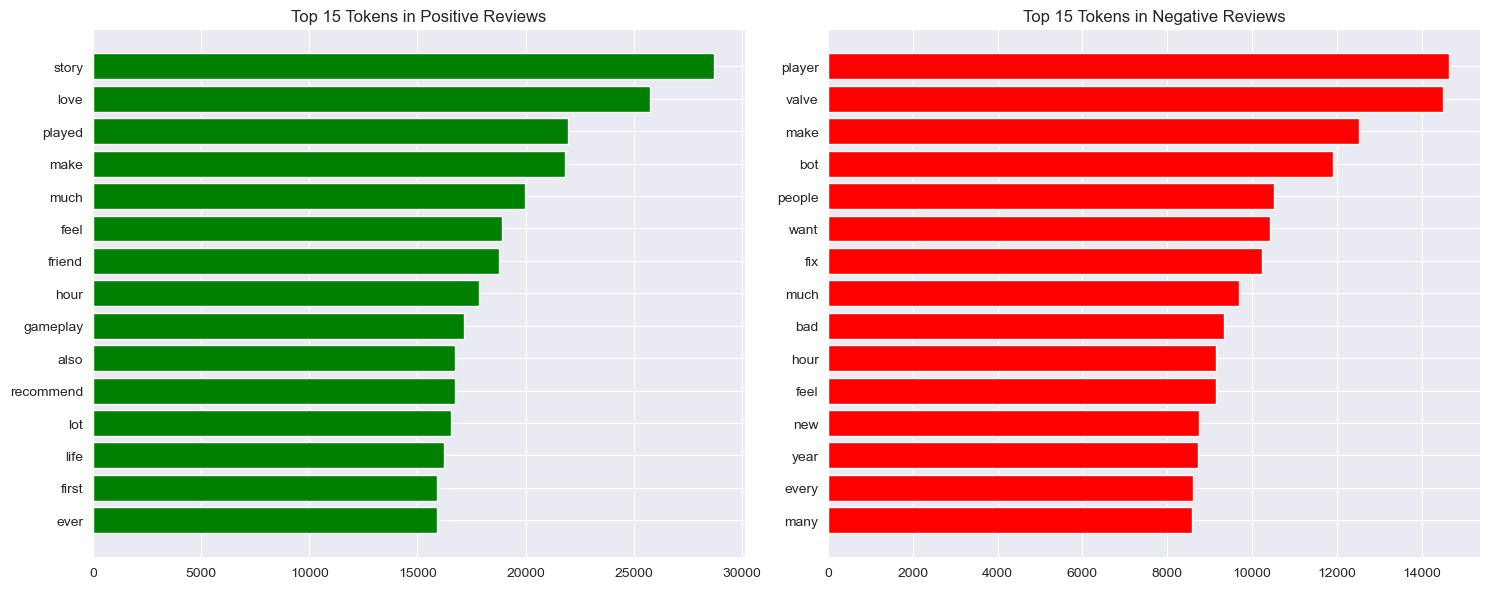

In [50]:
# Separate positive and negative reviews
cleaned_pos = merged_data[merged_data['score'] == 1]
cleaned_neg = merged_data[merged_data['score'] == 0]

# Word frequency for positive reviews
# Flatten the list of lists into one list of tokens
positive_words = [word for tokens in cleaned_pos['filtered_tokens'] for word in tokens]
positive_freq = Counter(positive_words).most_common(15)

# Word frequency for negative reviews
# Flatten similarly for negative reviews
negative_words = [word for tokens in cleaned_neg['filtered_tokens'] for word in tokens]
negative_freq = Counter(negative_words).most_common(15)

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Positive words
pos_words, pos_counts = zip(*positive_freq)
axes[0].barh(pos_words[::-1], pos_counts[::-1], color='green')
axes[0].set_title("Top 15 Tokens in Positive Reviews")
axes[0].tick_params(axis='x')

# Negative words
neg_words, neg_counts = zip(*negative_freq)
axes[1].barh(neg_words[::-1], neg_counts[::-1], color='red')
axes[1].set_title("Top 15 Tokens in Negative Reviews")
axes[1].tick_params(axis='x')

plt.tight_layout()
plt.show()

Analysing ngram frequency. starting with bigrams, most insightful.

Most common bigrams: [(('half', 'life'), 8767), (('ever', 'played'), 5464), (('highly', 'recommend'), 3463), (('let', 'u'), 2892), (('dark', 'soul'), 2618), (('early', 'access'), 2596), (('black', 'mesa'), 2536), (('open', 'world'), 2480), (('new', 'player'), 2452), (('opposing', 'force'), 2151), (('ever', 'made'), 2145), (('blue', 'shift'), 2076), (('hate', 'hate'), 2046), (('year', 'ago'), 2003), (('team', 'fortress'), 1952), (('year', 'old'), 1934), (('much', 'better'), 1899), (('left', 'dead'), 1888), (('please', 'please'), 1798), (('source', 'engine'), 1792), (('hard', 'drive'), 1706), (('come', 'back'), 1698), (('worth', 'price'), 1698), (('peak', 'peak'), 1677), (('make', 'feel'), 1653)]


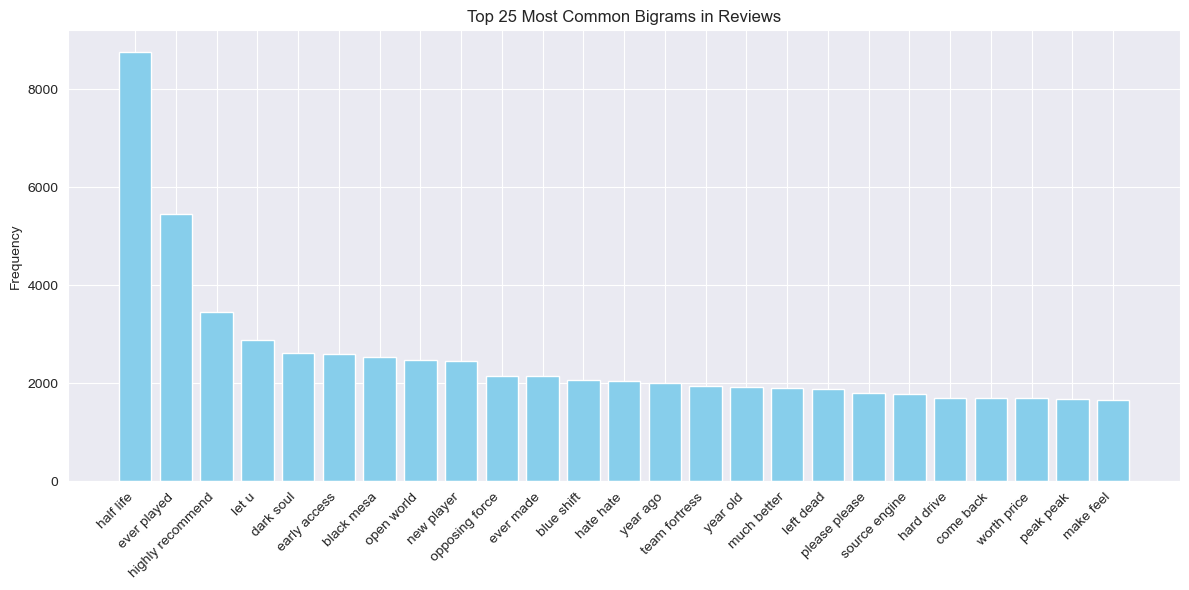

In [23]:
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter

# Flatten the list of filtered tokens from all reviews
all_filtered_tokens = [word for tokens in merged_data['filtered_tokens'] for word in tokens]

# Extract bigrams from the flattened token list
bigrams = list(ngrams(all_filtered_tokens, 2))

# Count bigram frequencies
bigram_freq = Counter(bigrams).most_common(25)

# Print the top 25 bigrams
print("Most common bigrams:", bigram_freq)

# Prepare data for visualization
bigram_labels, bigram_counts = zip(*bigram_freq)
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]  # Convert tuple of tokens to a single string

# Plot the top 25 bigrams
plt.figure(figsize=(12, 6))
plt.bar(bigram_labels, bigram_counts, color='skyblue')
plt.title("Top 25 Most Common Bigrams in Reviews")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

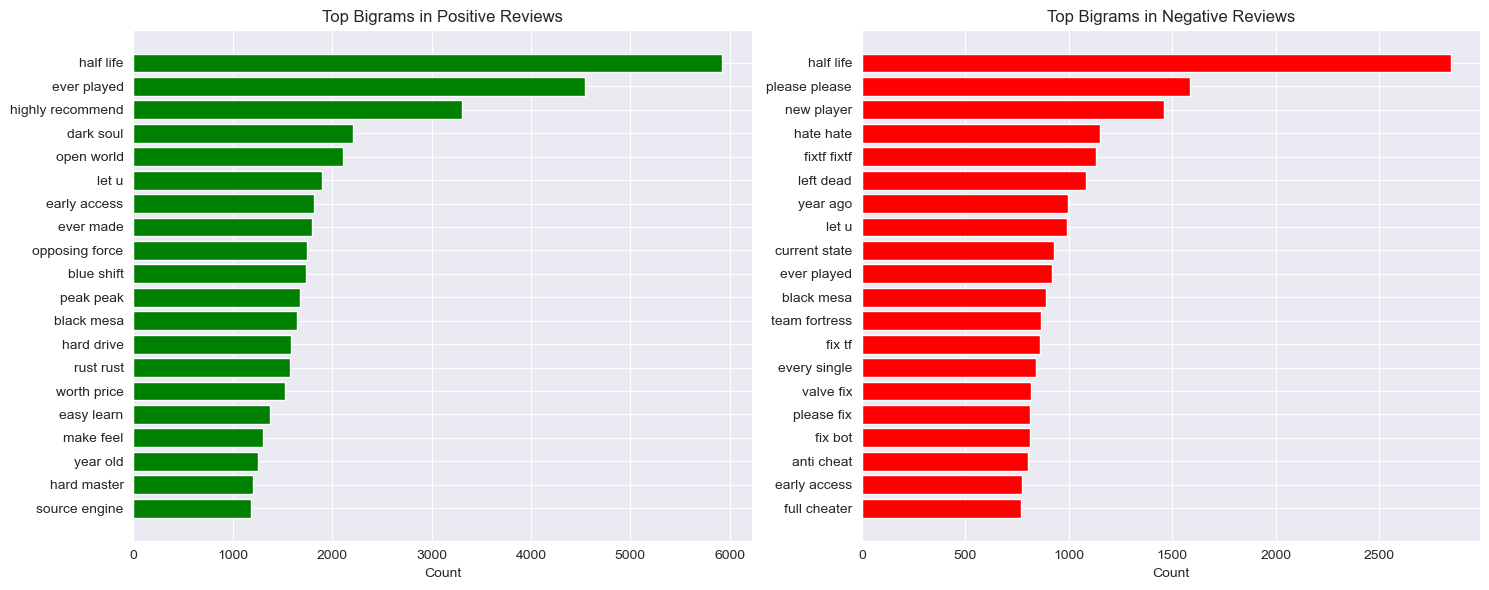

In [48]:
import matplotlib.pyplot as plt
from nltk import ngrams
from collections import Counter

# 1. Flatten tokens for positive reviews
positive_words = [
    word 
    for tokens in merged_data[merged_data['score'] == 1]['filtered_tokens'] 
    for word in tokens
]

# 2. Flatten tokens for negative reviews
negative_words = [
    word 
    for tokens in merged_data[merged_data['score'] == 0]['filtered_tokens'] 
    for word in tokens
]

# 3. Create bigrams
positive_bigrams = list(ngrams(positive_words, 2))
negative_bigrams = list(ngrams(negative_words, 2))

# 4. Count bigram frequencies
positive_bigram_freq = Counter(positive_bigrams).most_common(20)
negative_bigram_freq = Counter(negative_bigrams).most_common(20)

# 5. Prepare data for visualization 
positive_labels, positive_counts = zip(*positive_bigram_freq)
positive_labels = [' '.join(bigram) for bigram in positive_labels]

negative_labels, negative_counts = zip(*negative_bigram_freq)
negative_labels = [' '.join(bigram) for bigram in negative_labels]

# 6. Plot horizontal bar charts
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 

# Positive bigrams (horizontal bars)
axes[0].barh(positive_labels[::-1], positive_counts[::-1], color='green')  
axes[0].set_title("Top Bigrams in Positive Reviews")
axes[0].set_xlabel("Count")  # Add X-axis label

# Negative bigrams (horizontal bars)
axes[1].barh(negative_labels[::-1], negative_counts[::-1], color='red')   
axes[1].set_title("Top Bigrams in Negative Reviews")
axes[1].set_xlabel("Count")  # Add X-axis label

plt.tight_layout()
plt.show()

Analyse word frequency per game tier

In [25]:
from collections import Counter

word_freq_by_tier = {}
for tier, group in merged_data[merged_data['score'] == 0].groupby('ownership_tier'):
    # Combine all text for the tier into a single string
    all_text = [word for tokens in group['filtered_tokens'] for word in tokens]
    # Calculate word frequencies
    word_freq_by_tier[tier] = Counter(all_text)

# Display the most common words for each tier
for tier, counter in word_freq_by_tier.items():
    print(f"\nMost common words in {tier} ownership games:")
    print(counter.most_common(10))

C:\Users\vnvtr\AppData\Local\Temp\ipykernel_43816\4251746113.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tier, group in merged_data[merged_data['score'] == 0].groupby('ownership_tier'):



Most common words in Low ownership games:
[('make', 3966), ('feel', 3593), ('want', 3164), ('much', 3103), ('thing', 2921), ('story', 2899), ('hour', 2869), ('way', 2840), ('bad', 2790), ('also', 2607)]

Most common words in Medium ownership games:
[('player', 3400), ('make', 3372), ('feel', 3064), ('much', 3011), ('way', 2806), ('people', 2792), ('want', 2769), ('bad', 2642), ('hour', 2633), ('first', 2632)]

Most common words in High ownership games:
[('valve', 11929), ('bot', 11072), ('player', 8642), ('fix', 7378), ('cheater', 7066), ('people', 5632), ('make', 5196), ('community', 4838), ('year', 4734), ('want', 4490)]


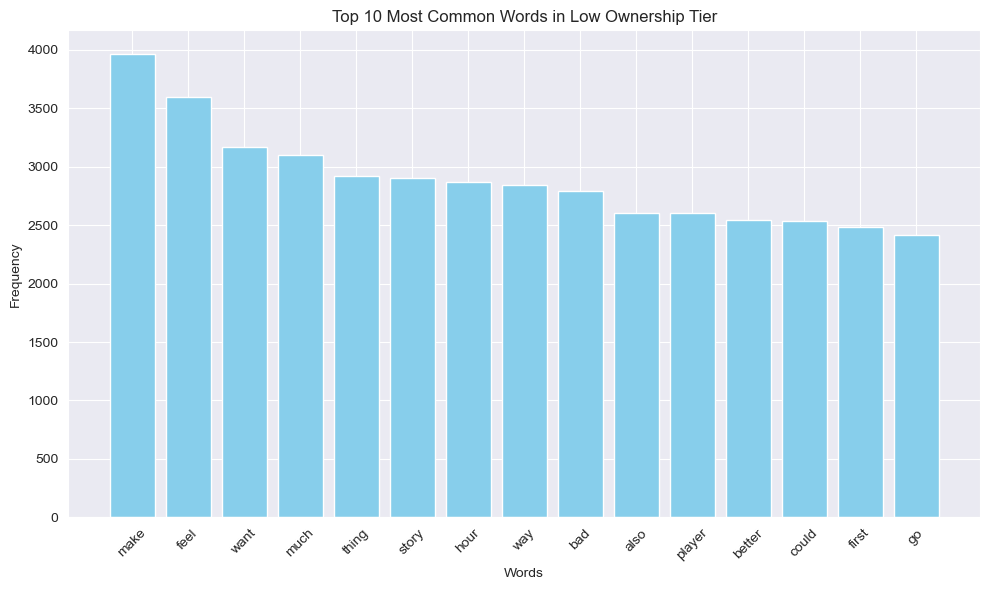

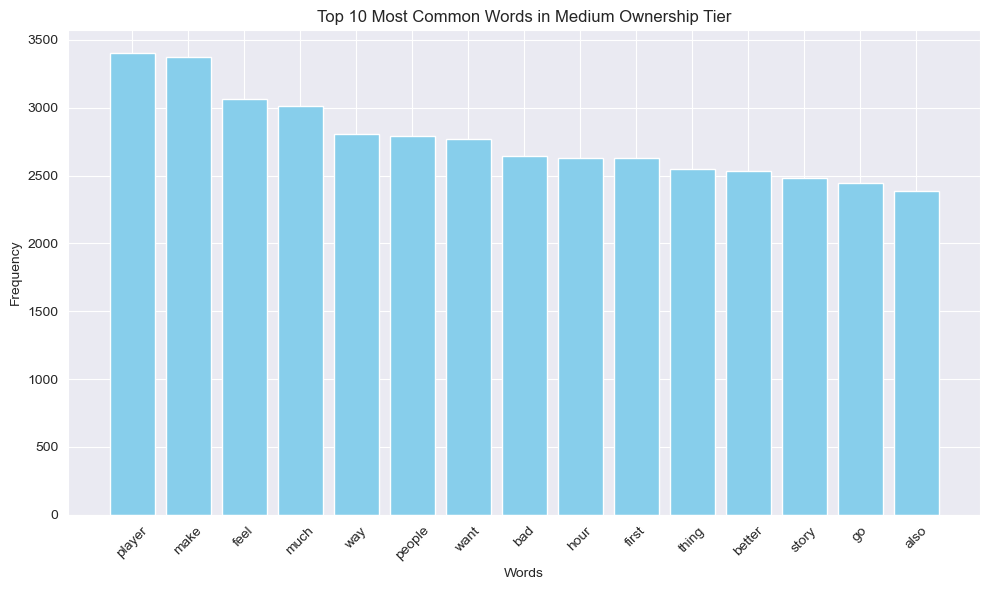

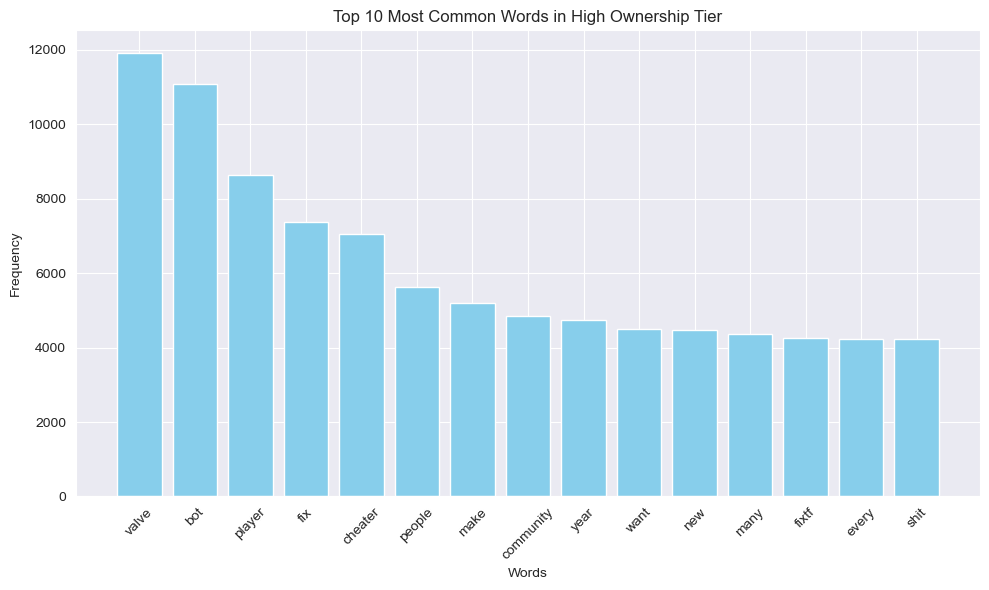

In [26]:
# Plot the top 10 most common words for each ownership tier
for tier, counter in word_freq_by_tier.items():
    # Get the top 10 words and their frequencies
    most_common = counter.most_common(15)
    words, counts = zip(*most_common)
    
    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top 10 Most Common Words in {tier} Ownership Tier")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Analysing bigrams by ownership tier 

In [27]:
from nltk import ngrams

bigrams_tiers = {}
for tier, group in merged_data[merged_data.score == 1].groupby('ownership_tier'):
    all_text = [word for tokens in group['filtered_tokens'] for word in tokens]
    bigrams = list(ngrams(all_text, 2))
    bigrams_tiers[tier] = Counter(bigrams).most_common(15)
    print(f"\nMost common bigrams {tier} tier:", bigrams_tiers[tier])

C:\Users\vnvtr\AppData\Local\Temp\ipykernel_43816\2931663135.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tier, group in merged_data[merged_data.score == 1].groupby('ownership_tier'):



Most common bigrams Low tier: [(('half', 'life'), 3472), (('opposing', 'force'), 1732), (('blue', 'shift'), 1704), (('ever', 'played'), 1700), (('black', 'mesa'), 1577), (('highly', 'recommend'), 1535), (('dark', 'soul'), 983), (('open', 'world'), 894), (('let', 'u'), 809), (('dragon', 'age'), 754), (('make', 'feel'), 669), (('worth', 'price'), 657), (('alien', 'swarm'), 656), (('hard', 'drive'), 631), (('voice', 'acting'), 619)]

Most common bigrams Medium tier: [(('ever', 'played'), 1763), (('peak', 'peak'), 1620), (('half', 'life'), 1490), (('early', 'access'), 1210), (('highly', 'recommend'), 1156), (('forest', 'forest'), 916), (('team', 'fortress'), 886), (('counter', 'strike'), 833), (('factory', 'must'), 829), (('dark', 'soul'), 828), (('rock', 'stone'), 824), (('ever', 'made'), 822), (('fire', 'hole'), 820), (('hole', 'fire'), 747), (('let', 'u'), 720)]

Most common bigrams High tier: [(('rust', 'rust'), 1575), (('ever', 'played'), 1081), (('half', 'life'), 960), (('highly', '

ValueError: not enough values to unpack (expected 2, got 1)

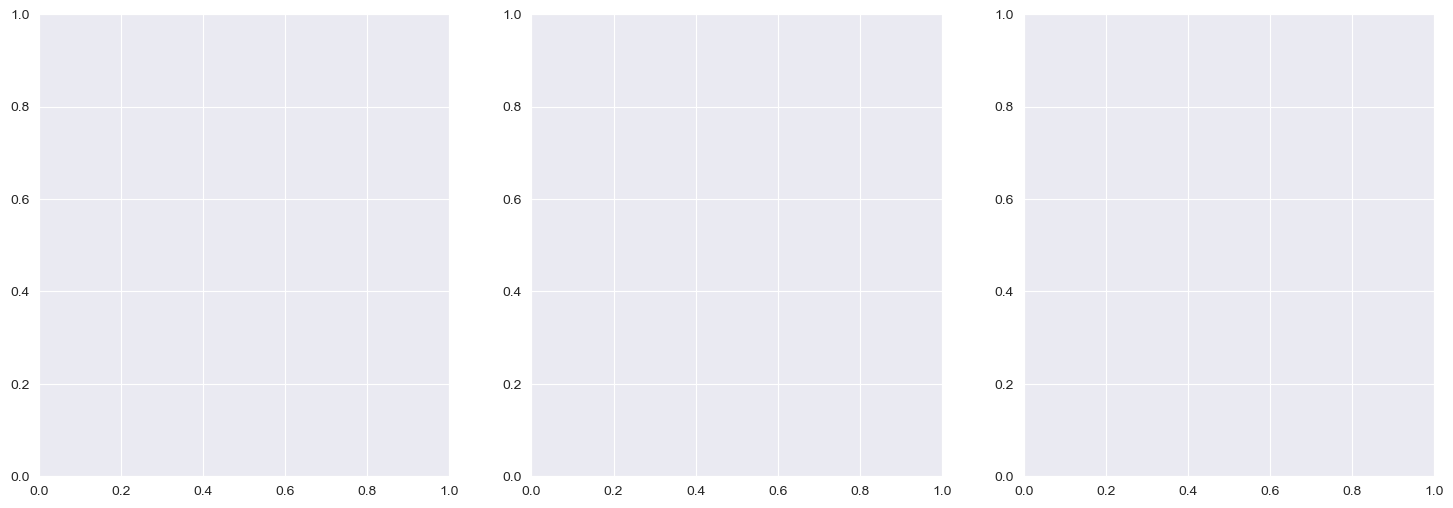

In [53]:
# Create a figure with subplots for each tier
n_tiers = len(word_freq_by_tier)
fig, axes = plt.subplots(1, n_tiers, figsize=(6*n_tiers, 6)) 

# Plot each tier in its own subplot
for (tier, counter), ax in zip(word_freq_by_tier.items(), axes):
    bigrams, counts = zip(*counter)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    # Create the bar chart in the assigned subplot
    ax.bar(bigram_labels, counts, color='skyblue')
    ax.set_title(f"Top Bigrams in {tier} Tier")
    ax.set_xlabel("Bigram")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()